Recurrent Neural Networks

6.2 Veri seti hazırlanması

In [8]:
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense , Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

import warnings
warnings.filterwarnings('ignore')

In [9]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# padding
maxlen = 100
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test  = pad_sequences(x_test, maxlen=maxlen)

6.3 model olusturulamsı

In [10]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=hp.Int('embedding_output', min_value = 32, max_value = 128,step = 32), input_length=maxlen))
    model.add(SimpleRNN(units= hp.Int('rnn_units', 32, 128, 32)))
    model.add(Dropout(rate = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

    return model

6.4 hp arama ve model egitimi

In [11]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir',
    project_name='imdb_rnn')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=2, validation_split=0.2, callbacks=[early_stopping])

Trial 2 Complete [00h 00m 20s]
val_loss: 0.4655713737010956

Best val_loss So Far: 0.4655713737010956
Total elapsed time: 00h 00m 50s


6.5 Modelin Test edilmesi ve görsellestirilmesi

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8685 - accuracy: 0.7896 - loss: 0.4649
Test Loss: 0.4609748125076294, test accuracy: 0.790, test AUC: 0.873
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     12500
           1       0.82      0.75      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



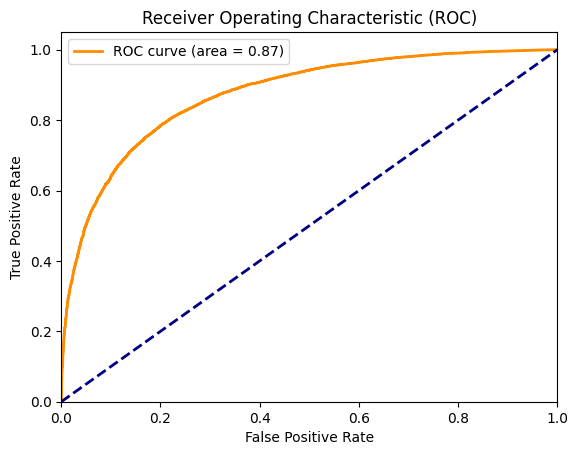

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

loss , accuracy, auc_score = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, test accuracy: {accuracy:.3f}, test AUC: {auc_score:.3f}")

y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

fpr , tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f"ROC curve (area = {roc_auc:.2f})"% roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()